In [ ]:
import yaml
import os
import torch
from fastaccent.model import FastAccentTTS
from dataset import SingleAccentDataset
from train_util import to_device
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from fastaccent.loss import FastAccentLoss
from IPython.display import Audio
from torch.utils.data import DataLoader
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = "cuda"



In [ ]:
american_preprocess_config = "config/single_accent_config/preprocess_config.yaml"
american_model_config = "config/single_accent_config/model_config.yaml"
american_train_config = "config/single_accent_config/train_config.yaml"
american_preprocess_config = yaml.load(
    open(american_preprocess_config, "r"), Loader=yaml.FullLoader
)
american_model_config = yaml.load(open(american_model_config, "r"), Loader=yaml.FullLoader)
american_train_config = yaml.load(open(american_train_config, "r"), Loader=yaml.FullLoader)
american_train_config['path']['ckpt_path'] = american_train_config['path']['ckpt_path'].format("american_english")
american_train_config['path']['log_path'] = american_train_config['path']['log_path'].format("american_english")
american_train_config['path']['result_path'] = american_train_config['path']['result_path'].format("american_english")
configs = (american_preprocess_config, american_model_config, american_train_config)

# Get model
american_model = FastAccentTTS(**american_model_config).to(device)
ckpt_path = os.path.join(
    american_train_config["path"]["ckpt_path"],
    f"200000.pth.tar",
)
ckpt = torch.load(ckpt_path, weights_only=False)
# ckpt["model"] = {k[7:]: v for k,v in ckpt["model"].items()}
american_model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
british_preprocess_config = "config/single_accent_config_british/preprocess_config.yaml"
british_model_config = "config/single_accent_config_british/model_config.yaml"
british_train_config = "config/single_accent_config_british/train_config.yaml"
british_preprocess_config = yaml.load(
    open(british_preprocess_config, "r"), Loader=yaml.FullLoader
)
british_model_config = yaml.load(open(british_model_config, "r"), Loader=yaml.FullLoader)
british_train_config = yaml.load(open(british_train_config, "r"), Loader=yaml.FullLoader)
british_train_config['path']['ckpt_path'] = british_train_config['path']['ckpt_path'].format("british_english")
british_train_config['path']['log_path'] = british_train_config['path']['log_path'].format("british_english")
british_train_config['path']['result_path'] = british_train_config['path']['result_path'].format("british_english")
configs = (british_preprocess_config, british_model_config, british_train_config)

# Get model
british_model = FastAccentTTS(**british_model_config).to(device)
ckpt_path = os.path.join(
    american_train_config["path"]["ckpt_path"],
    f"200000.pth.tar",
)
ckpt = torch.load(ckpt_path, weights_only=False)
# ckpt["model"] = {k[7:]: v for k,v in ckpt["model"].items()}
british_model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [4]:
american_dataset = SingleAccentDataset(
        "test.json", american_preprocess_config, american_train_config, sort=False, drop_last=False
    )
british_dataset = SingleAccentDataset(
        "test.json", british_preprocess_config, british_train_config, sort=False, drop_last=False
    )

In [9]:
Loss = FastAccentLoss().to(device)
loader = DataLoader(
        american_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=american_dataset.collate_fn,
    )
# Evaluation
american_loss_sum = 0
british_loss_sum = 0
for batchs in loader:
    for batch in batchs:
        batch = to_device(batch, device)
        with torch.no_grad():
            # Forward
            american_output = american_model(*(batch[1:7]))
            british_output = british_model(*(batch[1:7]))

            # Cal Loss
            american_loss = Loss(american_output, batch[7])
            british_loss = Loss(british_output, batch[7])
            american_loss_sum += american_loss.item() * len(batch[0])
            british_loss_sum += british_loss.item() * len(batch[0])

american_loss_mean = american_loss_sum / len(american_dataset)
british_loss_mean = british_loss_sum / len(american_dataset)
print(f"{american_loss_mean}, {british_loss_mean}")

0.23387549896240234, 0.23344426743984223


In [10]:
Loss = FastAccentLoss().to(device)
loader = DataLoader(
        british_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=british_dataset.collate_fn,
    )
# Evaluation
american_loss_sum = 0
british_loss_sum = 0
for batchs in loader:
    for batch in batchs:
        batch = to_device(batch, device)
        with torch.no_grad():
            # Forward
            american_output = american_model(*(batch[1:7]))
            british_output = british_model(*(batch[1:7]))

            # Cal Loss
            american_loss = Loss(american_output, batch[7])
            british_loss = Loss(british_output, batch[7])
            american_loss_sum += american_loss.item() * len(batch[0])
            british_loss_sum += british_loss.item() * len(batch[0])

american_loss_mean = american_loss_sum / len(british_dataset)
british_loss_mean = british_loss_sum / len(british_dataset)
print(f"{american_loss_mean}, {british_loss_mean}")

0.30734545712471006, 0.30728004450798035


In [99]:
american_data_sample = american_dataset.collate_fn([american_dataset[1000]])[0]
american_data_sample = to_device(american_data_sample, device)
british_data_sample = british_dataset.collate_fn([british_dataset[1000]])[0]
british_data_sample = to_device(british_data_sample, device)

In [100]:
american_output_american = american_model(*(american_data_sample[1:7]))
american_output_british = british_model(*(american_data_sample[1:7]))
british_output_american = american_model(*(british_data_sample[1:7]))
british_output_british = british_model(*(british_data_sample[1:7]))

In [101]:
def plot_sparc(prediction_american, prediction_british, ground_truth, phones, durs):
    # Create a figure with 15 subplots stacked vertically
    fig, axes = plt.subplots(12, 1, figsize=(30, 25))

    names = ["ULX", "ULY", "LLX", "LLY", "LIX", "LIY", "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]

    for i in range(12):
        total_dur = 0
        axes[i].plot(prediction_american[:, i], color='blue', label=f'Predicted American')
        axes[i].plot(prediction_british[:, i], color='green', label=f'Predicted British')
        axes[i].plot(ground_truth[:, i], color='orange', label=f'Ground Truth')
        axes[i].set_title(f'{names[i]}')
        axes[i].legend(loc='upper right')
        for j in range(len(phones)):
            phone = phones[j]
            dur = durs[j]
            axes[i].text((2*total_dur+dur)/2,-2, phone, horizontalalignment='center',
                verticalalignment='center',)
            total_dur += dur

    # Set a general label for the y-axis
    for ax in axes:
        ax.set_ylabel('Value')

    # Set a general label for the x-axis
    plt.xlabel('Index')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

    american_corr = {item[0]: float(item[1]) for item in zip(names, list(pearsonr(prediction_american, ground_truth).statistic))}
    british_corr = {item[0]: float(item[1]) for item in zip(names, list(pearsonr(prediction_british, ground_truth).statistic))}
    return american_corr, british_corr

In [102]:
american_prediction = american_output_american[0][0][:, :12].detach().cpu().numpy()
british_prediction = american_output_british[0][0][:, :12].detach().cpu().numpy()
ground_truth = american_data_sample[7][0][:, :12].detach().cpu().numpy()

In [103]:
with open(f"/data/nzxyin/GLOBE/preprocess_default/text/{american_data_sample[0][0]}.txt", "r") as f:
    phones = f.readline().split(" ")
durs = np.load(f"/data/nzxyin/GLOBE/preprocess_default/durations/{american_data_sample[0][0]}.npy")

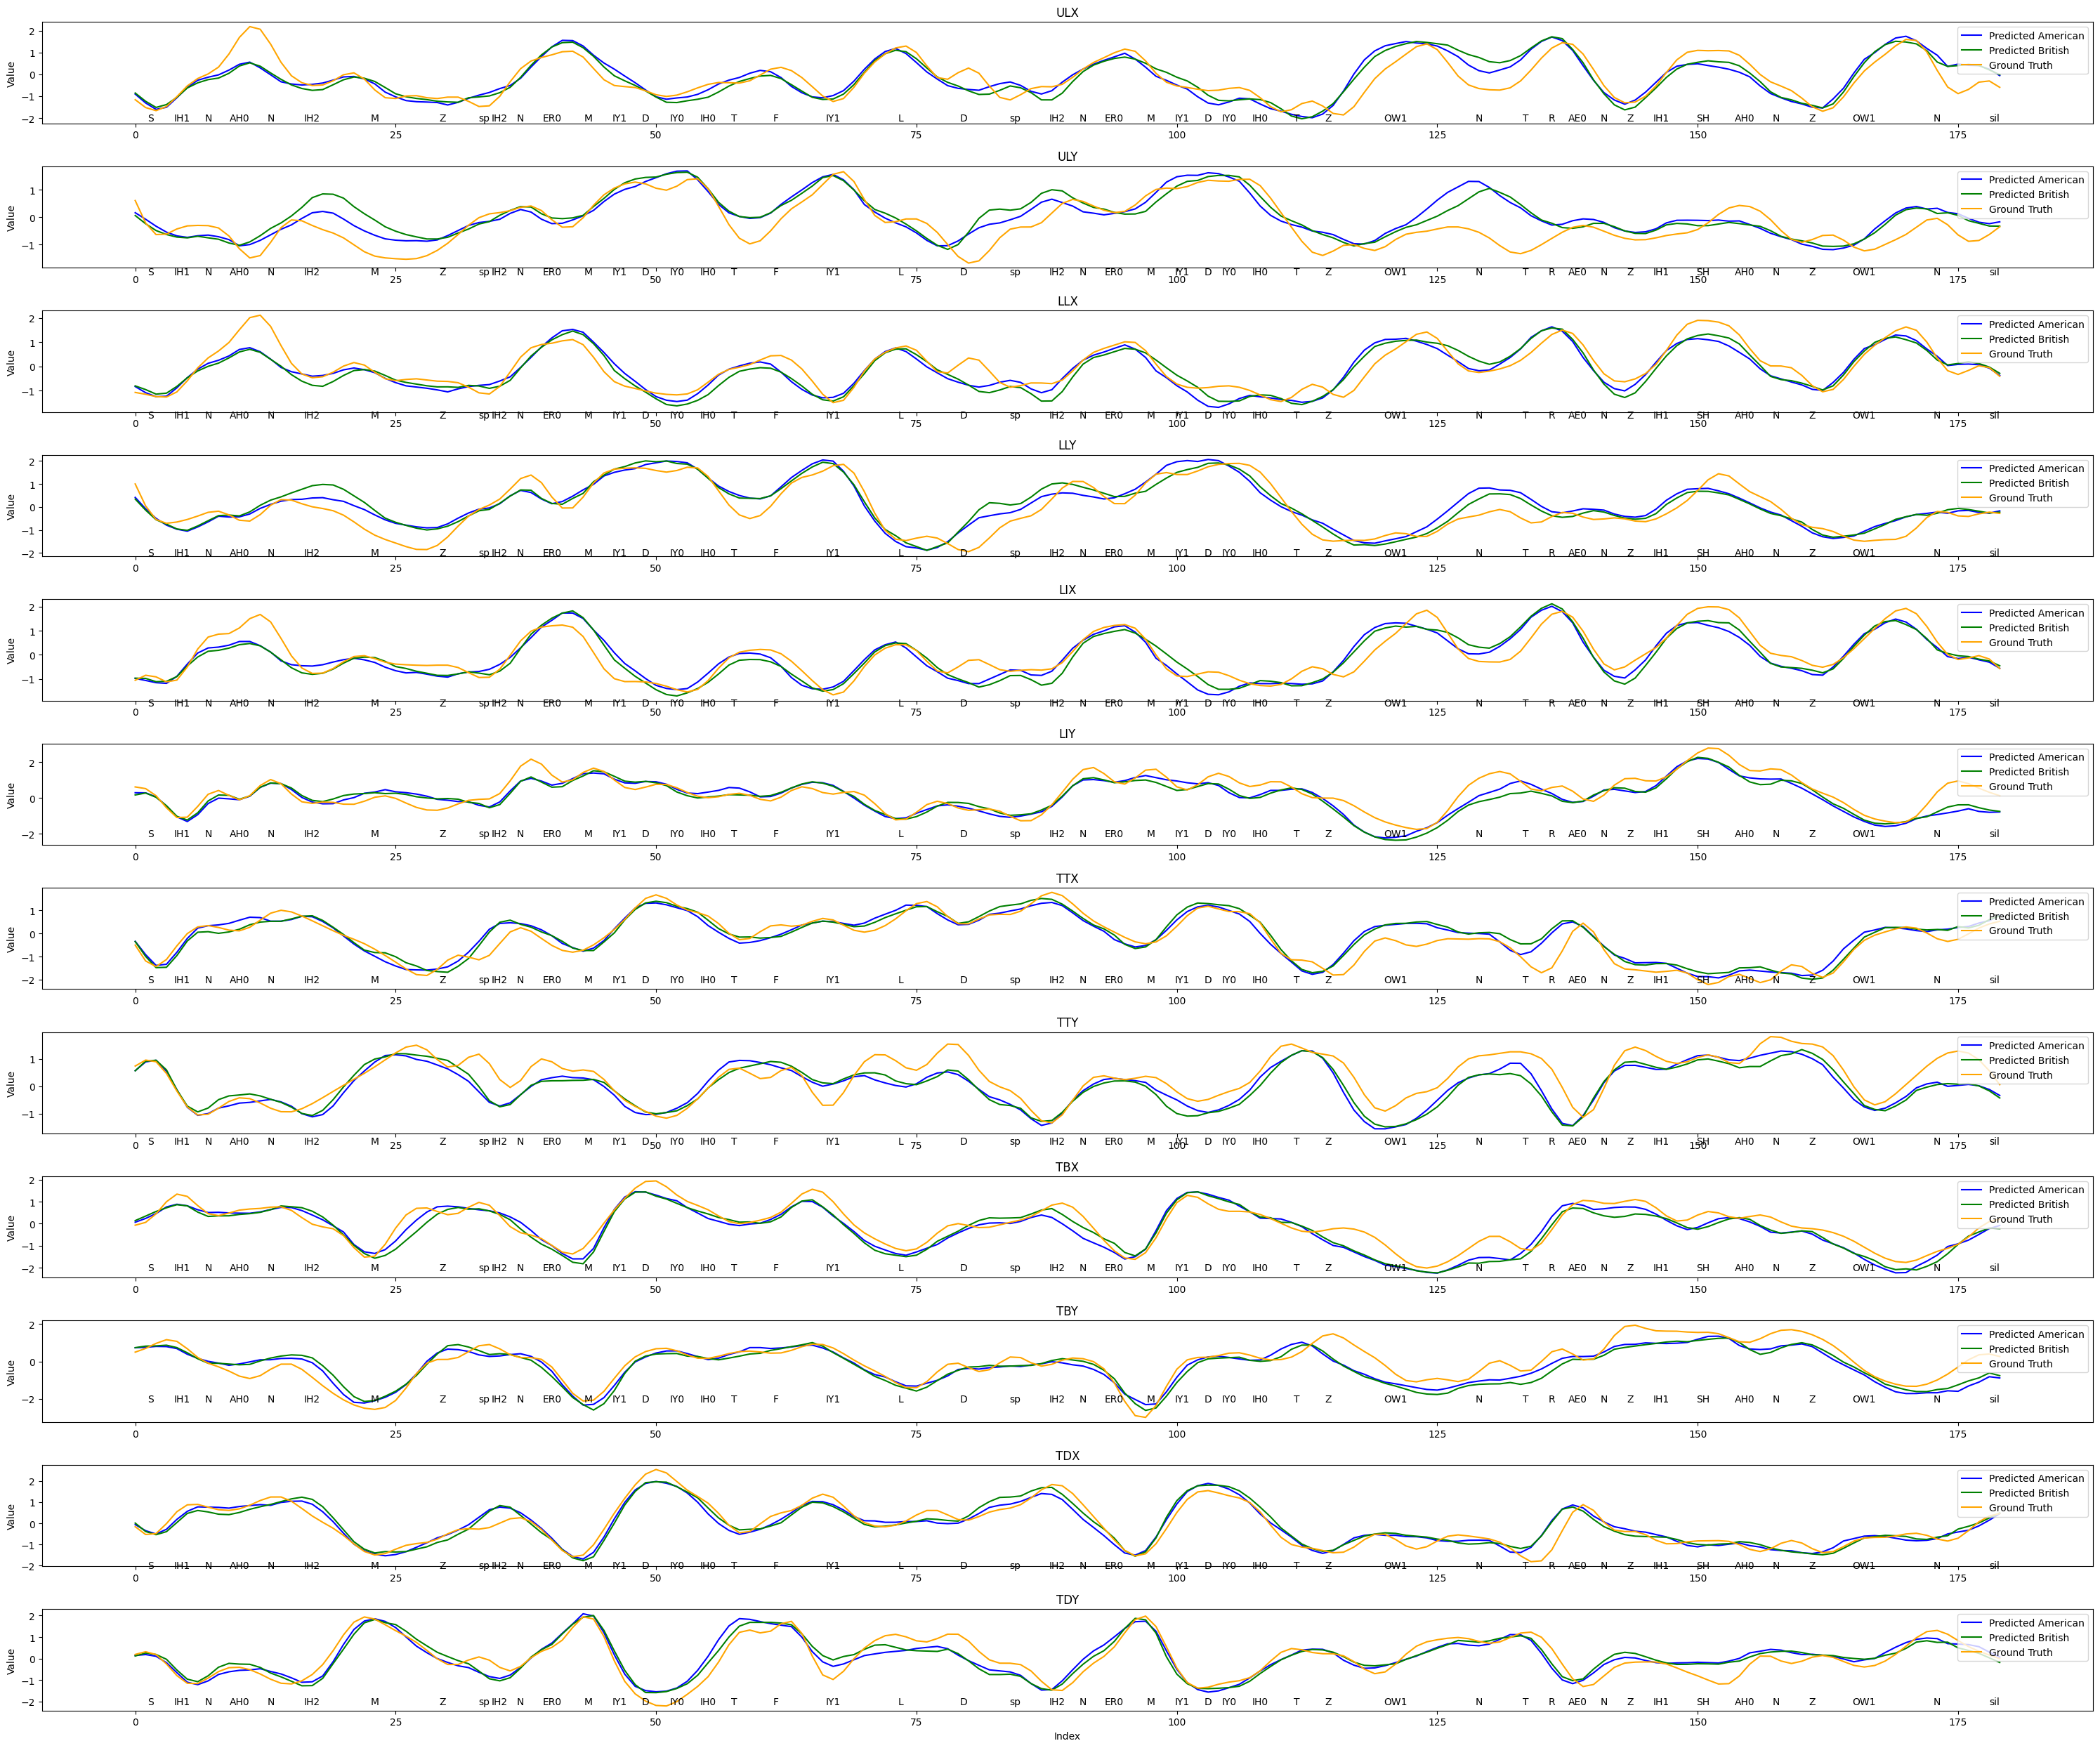

In [104]:
corr = plot_sparc(american_prediction, british_prediction, ground_truth, phones, durs)

In [105]:
corr

({'ULX': 0.8138177990913391,
  'ULY': 0.7720025181770325,
  'LLX': 0.8730736970901489,
  'LLY': 0.8916163444519043,
  'LIX': 0.872207522392273,
  'LIY': 0.8731433749198914,
  'TTX': 0.922749400138855,
  'TTY': 0.8444637656211853,
  'TBX': 0.9292234182357788,
  'TBY': 0.8848002552986145,
  'TDX': 0.9401044249534607,
  'TDY': 0.8962417840957642},
 {'ULX': 0.8141506910324097,
  'ULY': 0.7508180737495422,
  'LLX': 0.879727303981781,
  'LLY': 0.8879218101501465,
  'LIX': 0.8818037509918213,
  'LIY': 0.8688711524009705,
  'TTX': 0.9224885106086731,
  'TTY': 0.8325029015541077,
  'TBX': 0.9264751076698303,
  'TBY': 0.8735891580581665,
  'TDX': 0.9343864917755127,
  'TDY': 0.90024334192276})

In [106]:
{"American Correlations": sum(corr[0][k] for k in corr[0])/12,
 "British Correlations": sum(corr[1][k] for k in corr[1])/12}

{'American Correlations': 0.8761203587055206,
 'British Correlations': 0.8727481911579767}

In [107]:
american_prediction = british_output_american[0][0][:, :12].detach().cpu().numpy()
british_prediction = british_output_british[0][0][:, :12].detach().cpu().numpy()
ground_truth = british_data_sample[7][0][:, :12].detach().cpu().numpy()

In [108]:
with open(f"/data/nzxyin/GLOBE/preprocess_default/text/{british_data_sample[0][0]}.txt", "r") as f:
    phones = f.readline().split(" ")
durs = np.load(f"/data/nzxyin/GLOBE/preprocess_default/durations/{british_data_sample[0][0]}.npy")

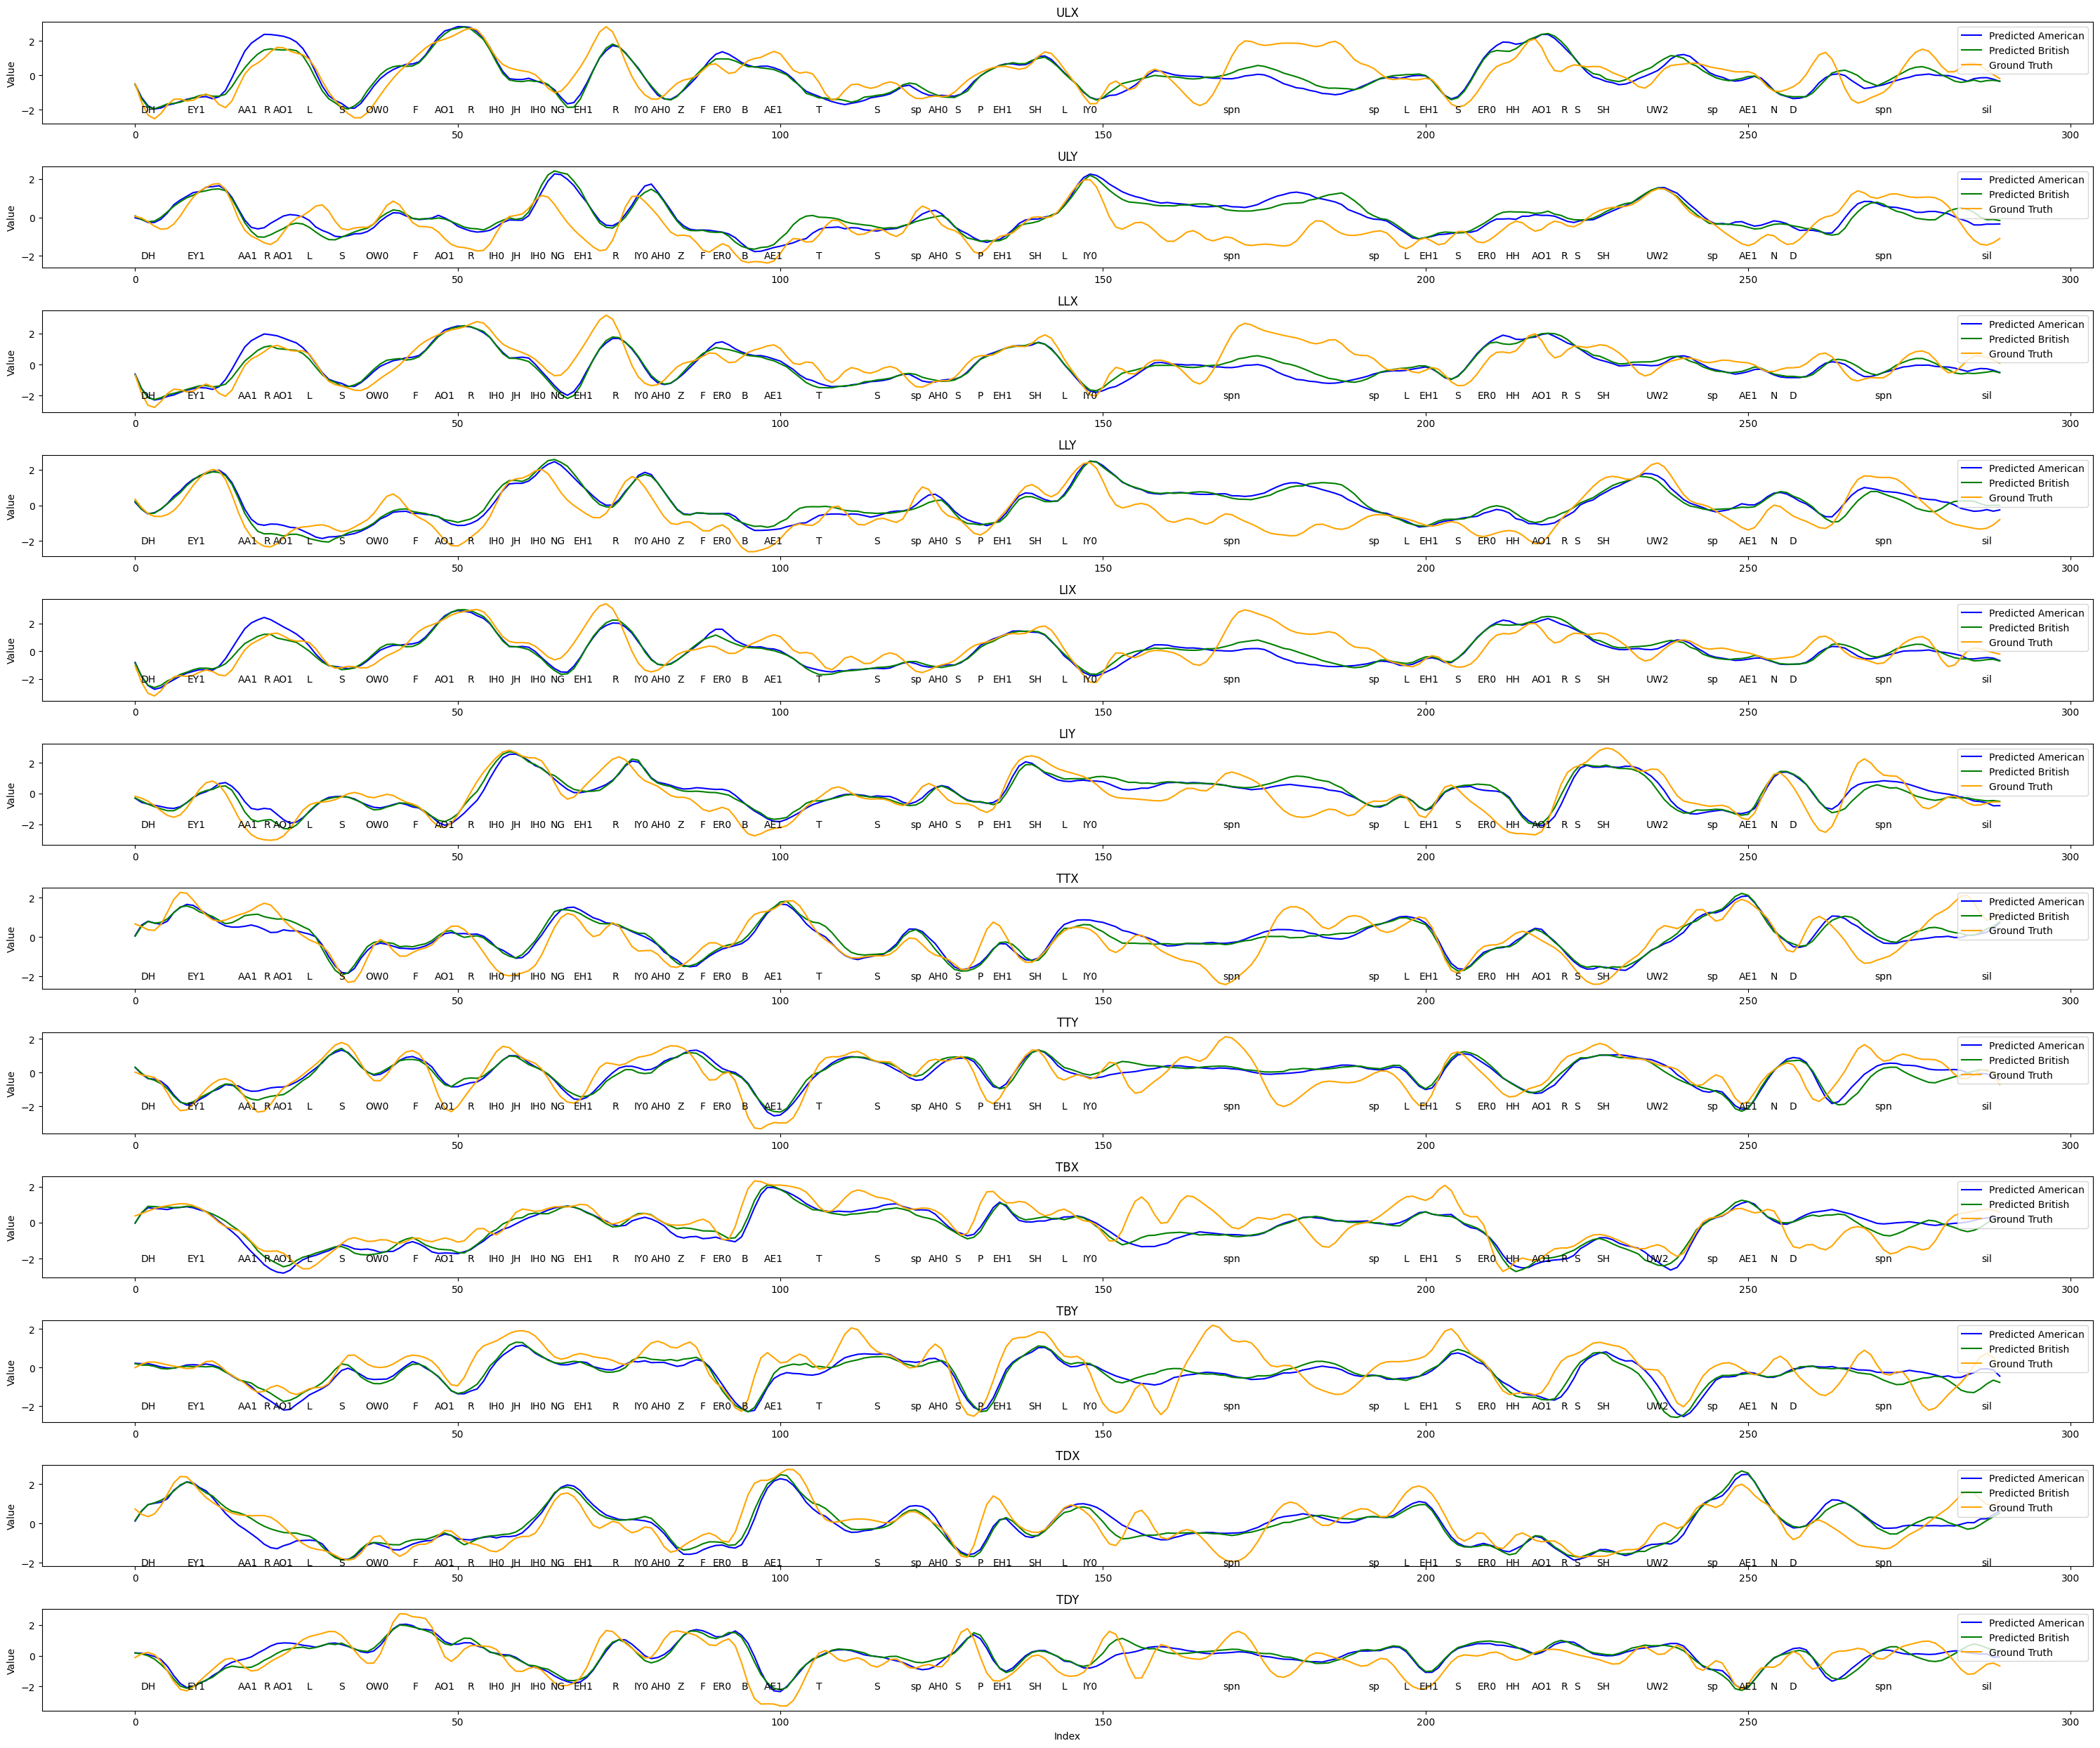

In [109]:
corr = plot_sparc(american_prediction, british_prediction, ground_truth, phones, durs)

In [110]:
corr

({'ULX': 0.6695999503135681,
  'ULY': 0.6193527579307556,
  'LLX': 0.6685970425605774,
  'LLY': 0.7375955581665039,
  'LIX': 0.708976686000824,
  'LIY': 0.8030152320861816,
  'TTX': 0.7739490866661072,
  'TTY': 0.7725645303726196,
  'TBX': 0.7387768030166626,
  'TBY': 0.658442497253418,
  'TDX': 0.7921614050865173,
  'TDY': 0.7293188571929932},
 {'ULX': 0.7124389410018921,
  'ULY': 0.5885157585144043,
  'LLX': 0.7275201082229614,
  'LLY': 0.6858597993850708,
  'LIX': 0.7672221660614014,
  'LIY': 0.7789660096168518,
  'TTX': 0.7901051044464111,
  'TTY': 0.7149004340171814,
  'TBX': 0.7692579030990601,
  'TBY': 0.6380713582038879,
  'TDX': 0.8153511881828308,
  'TDY': 0.7103426456451416})

In [111]:
{"American Correlations": sum(corr[0][k] for k in corr[0])/12,
 "British Correlations": sum(corr[1][k] for k in corr[1])/12}

{'American Correlations': 0.7226958672205607,
 'British Correlations': 0.7248792846997579}